# NLP Modeling | Lucas Kimball | Oct 2023 | Phase 4 Project | Flatiron School

# Business Problem

The New York Times is writing an article comparing Apple and Google. They want cold hard data to back up what they say about public sentiment towards these companies and they've hired me to provide them that information. They want a model that can classify tweets as positive, negative, or neutral towards these companies and one that will work on the much larger database or tweets NYT has already got their hands on. 

# Data Source

The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

## Exploring the Data 

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

[nltk_data] Downloading package punkt to /Users/lkimball/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

## Data Cleaning

In [7]:
# Use dropna to remove rows with NaN values in the specified column
df.dropna(subset=['tweet_text'], inplace=True)

In [8]:
# Define a function to clean the text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stopwords.words('english')]
    # Rejoin the words into a cleaned text
    cleaned_text = ' '.join(words)
    return cleaned_text

# Apply the cleaning function 

df['tweet_text'] = df['tweet_text'].apply(clean_text)

In [9]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,wesley83 3g iphone 3 hrs tweeting riseaustin d...,iPhone,Negative emotion
1,jessedee know fludapp awesome ipadiphone app y...,iPad or iPhone App,Positive emotion
2,swonderlin wait ipad 2 also sale sxsw,iPad,Positive emotion
3,sxsw hope years festival isnt crashy years iph...,iPad or iPhone App,Negative emotion
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive emotion


In [10]:
# Renaming a column
new_column_name = 'emotion'
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': new_column_name}, inplace=True)

In [11]:
# Renaming a column
new_column_name = 'company'
df.rename(columns={'emotion_in_tweet_is_directed_at': new_column_name}, inplace=True)

In [12]:
# Define a function to classify values into buckets
def classify_into_buckets(value):
    if isinstance(value, str):
        if 'iPad' in value or 'Apple' in value or 'iPad App' in value or 'iPhone App' in value or 'iPhone' in value or 'Other Apple product' in value:
            return 'Apple'
        elif 'Google' in value or 'Other Google product' in value:
            return 'Google'
        elif 'Android' in value or 'Android App' in value:
            return 'Android'
    return 'Other'  # Assign 'Other' to non-string or missing (NaN) values

# Create a new column with the categorized values
df['category'] = df['company'].apply(classify_into_buckets)


In [15]:
df['company'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: company, dtype: int64

In [16]:
df['category'].value_counts()

Other      5801
Apple      2409
Google      723
Android     159
Name: category, dtype: int64

In [19]:
# Drop records with 'Other' or 'Android' in the 'company' column
df = df[~df['category'].isin(['Other', 'Android'])]

In [22]:
# Drop the 'company' column
df = df.drop('company', axis=1)

In [26]:
df['emotion'].value_counts()

Positive        2531
Negative         503
Neutral           89
I can't tell       9
Name: emotion, dtype: int64

In [30]:
#drop all 'I can't tell"s
df = df[df['emotion'] != "I can't tell"]

In [31]:
df['category'].value_counts()

Apple     2402
Google     721
Name: category, dtype: int64

In [33]:
# Tokenize a specific column (e.g., 'text_column')
df['tokenized_text'] = df['tweet_text'].apply(word_tokenize)

In [34]:
df

,tweet_text,emotion,category,tokenized_text
0,wesley83 3g iphone 3 hrs tweeting riseaustin d...,Negative,Apple,"[wesley83, 3g, iphone, 3, hrs, tweeting, risea..."
1,jessedee know fludapp awesome ipadiphone app y...,Positive,Apple,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,swonderlin wait ipad 2 also sale sxsw,Positive,Apple,"[swonderlin, wait, ipad, 2, also, sale, sxsw]"
3,sxsw hope years festival isnt crashy years iph...,Negative,Apple,"[sxsw, hope, years, festival, isnt, crashy, ye..."
4,sxtxstate great stuff fri sxsw marissa mayer g...,Positive,Google,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...,...,...,...
9077,mention pr guy convinced switch back iphone gr...,Positive,Apple,"[mention, pr, guy, convinced, switch, back, ip..."
9079,quotpapyrussort like ipadquot nice lol sxsw la...,Positive,Apple,"[quotpapyrussort, like, ipadquot, nice, lol, s..."
9080,diller says google tv quotmight run playstatio...,Negative,Google,"[diller, says, google, tv, quotmight, run, pla..."
9085,ive always used camera iphone bc image stabili...,Positive,Apple,"[ive, always, used, camera, iphone, bc, image,..."


In [38]:
# Define a mapping dictionary
emotion_mapping = {
    'Positive': 2,
    'Negative': 0,
    'Neutral': 1
}

# Use the replace method to map the values in the 'emotion' column
df['emotion_label'] = df['emotion'].replace(emotion_mapping)


In [39]:
df.head()

,tweet_text,emotion,category,tokenized_text,emotion_label
0,wesley83 3g iphone 3 hrs tweeting riseaustin d...,Negative,Apple,"[wesley83, 3g, iphone, 3, hrs, tweeting, risea...",0
1,jessedee know fludapp awesome ipadiphone app y...,Positive,Apple,"[jessedee, know, fludapp, awesome, ipadiphone,...",2
2,swonderlin wait ipad 2 also sale sxsw,Positive,Apple,"[swonderlin, wait, ipad, 2, also, sale, sxsw]",2
3,sxsw hope years festival isnt crashy years iph...,Negative,Apple,"[sxsw, hope, years, festival, isnt, crashy, ye...",0
4,sxtxstate great stuff fri sxsw marissa mayer g...,Positive,Google,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",2


In [45]:
df['tokenized_text'].apply(type).value_counts()

<class 'list'>    3123
Name: tokenized_text, dtype: int64

## Modeling

For our modeling we iterated through a series of different models, lemming or stemming, and count vectorization or TF-IDF vectorization to find out which combination gave the best results. We picked AUC ROC score to measure results as we wanted our model to classify data the best, rather than focus on any one label. Our business problem is not sensitive towards positive, negative, or neutral results. For the same reason we displayed the average AUC ROC scores for different models across all emotion labels.

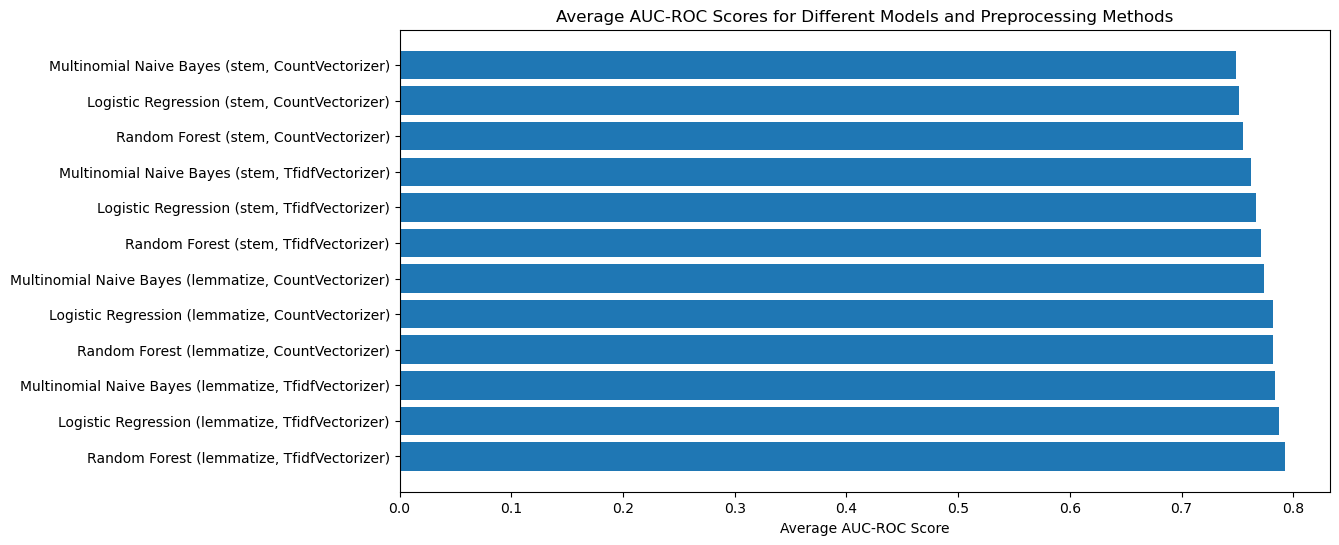

In [70]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['tokenized_text'], df['emotion_label'], test_size=0.25, random_state=42)

# Define custom pre-processing functions for stemming and lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

class TextPreprocessor(FunctionTransformer):
    def __init__(self, method='lemmatize'):
        self.method = method
        super().__init__(validate=None)

    def transform(self, X):
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        if isinstance(text, list):
            # If 'text' is a list, join the tokens into a single string
            text = ' '.join(text)

        # Tokenize the text
        tokens = nltk.word_tokenize(text)

        # Apply stemming or lemmatization based on the chosen method
        if self.method == 'stem':
            processed_tokens = [stemmer.stem(token) for token in tokens]
        else:
            processed_tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Join the processed tokens into a single string
        processed_text = ' '.join(processed_tokens)

        return processed_text

# Create a list of vectorization options
vectorization_options = [CountVectorizer(), TfidfVectorizer()]

# Create a list of classification models
models = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('Random Forest', RandomForestClassifier())
]

# Create lists to store AUC-ROC scores and model names
auc_roc_scores = []
model_names = []

# Create a figure and axis for the ROC curve plot
plt.figure(figsize=(12, 6))

# Create lists to store average AUC-ROC scores and model names
average_auc_roc_scores = []

# Iterate through all combinations of preprocessing, vectorization, and models
for preprocessing_option in ['stem', 'lemmatize']:
    for vectorization_option in vectorization_options:
        for model_name, model in models:
            # Create a pipeline with the current configuration
            pipeline = Pipeline([
                ('preprocess', TextPreprocessor(method=preprocessing_option)),
                ('vectorize', vectorization_option),
                ('model', model)
            ])

            # Fit the pipeline on the training data
            pipeline.fit(X_train, y_train)

            # Get class labels for multi-class classification
            classes = pipeline.classes_

            # Calculate the AUC-ROC scores for each class
            auc_roc_class_scores = []

            for class_index in range(len(classes)):
                y_true = (y_test == classes[class_index]).astype(int)
                y_pred_proba = pipeline.predict_proba(X_test)[:, class_index]
                auc_roc = roc_auc_score(y_true, y_pred_proba)
                auc_roc_class_scores.append(auc_roc)

            # Calculate the mean AUC-ROC score across all classes
            mean_auc_roc = np.mean(auc_roc_class_scores)

            # Store the model name and average AUC-ROC score
            model_names.append(f'{model_name} ({preprocessing_option}, {vectorization_option.__class__.__name__})')
            average_auc_roc_scores.append(mean_auc_roc)

        

# Plot the average AUC-ROC scores for different models
plt.barh(model_names, sorted(average_auc_roc_scores))
plt.xlabel('Average AUC-ROC Score')
plt.title('Average AUC-ROC Scores for Different Models and Preprocessing Methods')
plt.gca().invert_yaxis()
plt.show()

## Results

Using the above bar chart, we can see that model using lemmatization, TF-IDF vectorization, and a Random Forest Classifier performed best.

Across all of our findings we can see that Random Forest models consistently performed better than Log Regression or Multinomial NB, Lemming performed better than Stemming and TF-IDF performed better than Count. Therefore it checks out the a model comprised of the 3 best settings would perform the best overall.